

In this notebook, I will show first how to contact the TPM and counts across samples and then show how to perform DEG. To generate SWAN reports, we will use separate notebook since SWAN is not compatible with the latest version of pandas

## Load library

In [1]:
import pandas as pd
import numpy as np
import anndata as ad
from gtfparse import read_gtf

from utils import *

import warnings
warnings.filterwarnings("ignore")

## Get transcript information

Since kallisto only gives us `trainscript_id`, we need to gather other information such as transcript name or gene id and gene name using GTF. 

In this part, we show how we should do this.

In [22]:
gencode_gtf = read_gtf("data/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz").to_pandas()

gencode_gtf_transcript = gencode_gtf[gencode_gtf["feature"] == "transcript"]
gencode_gtf_transcript = gencode_gtf_transcript[['transcript_id', 
                                                 'transcript_type', 
                                                 'transcript_name', 
                                                 'gene_id', 
                                                 'gene_type', 
                                                 'gene_name']]
gencode_gtf_transcript.index = gencode_gtf_transcript.transcript_id.tolist()
gencode_gtf_transcript

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,transcript_id,transcript_type,transcript_name,gene_id,gene_type,gene_name
ENSMUST00000193812.2,ENSMUST00000193812.2,TEC,4933401J01Rik-201,ENSMUSG00000102693.2,TEC,4933401J01Rik
ENSMUST00000082908.3,ENSMUST00000082908.3,snRNA,Gm26206-201,ENSMUSG00000064842.3,snRNA,Gm26206
ENSMUST00000162897.2,ENSMUST00000162897.2,protein_coding_CDS_not_defined,Xkr4-203,ENSMUSG00000051951.6,protein_coding,Xkr4
ENSMUST00000159265.2,ENSMUST00000159265.2,protein_coding_CDS_not_defined,Xkr4-202,ENSMUSG00000051951.6,protein_coding,Xkr4
ENSMUST00000070533.5,ENSMUST00000070533.5,protein_coding,Xkr4-201,ENSMUSG00000051951.6,protein_coding,Xkr4
...,...,...,...,...,...,...
ENSMUST00000180208.2,ENSMUST00000180208.2,protein_coding,ENSMUST00000180208,ENSMUSG00000095475.2,protein_coding,ENSMUSG00000095475
ENSMUST00000178327.2,ENSMUST00000178327.2,protein_coding,ENSMUST00000178327,ENSMUSG00000094855.2,protein_coding,ENSMUSG00000094855
ENSMUST00000178569.2,ENSMUST00000178569.2,protein_coding,ENSMUST00000178569,ENSMUSG00000095019.2,protein_coding,ENSMUSG00000095019
ENSMUST00000179505.8,ENSMUST00000179505.8,protein_coding,ENSMUST00000179505,ENSMUSG00000095041.8,protein_coding,ENSMUSG00000095041


## Concate count and tpm matrices

After we grab transcript information from GTF file and clean it up, it's time to make count and TPM h5ad files in a way that `var` contains information regarding transcript and `obs` contains information about samples.


In [25]:
samples = pd.read_csv("data/sample_name.txt", header=None, sep='   ')[0].tolist()

metadata_sample_path = "data/sample_metadata.csv"

adata_count = None
adata_tpm = None

for sample in samples:
    transcript = pd.read_csv(f'data/output_{sample}/transcripts.txt', header=None, index_col=0)
    transcript.index.names = ['']
    counts = ad.read_mtx(f'data/output_{sample}/matrix.abundance.mtx', dtype='float32')[0]
    counts.obs.index = [sample]
    counts.var.index = transcript.index.tolist()
    
    tpm = ad.read_mtx(f'data/output_{sample}/matrix.abundance.tpm.mtx', dtype='float32')[0]
    tpm.obs.index = [sample]
    tpm.var.index = transcript.index.tolist()

    if adata_count is None:
        adata_count = counts.copy()
        adata_tpm = tpm.copy()
        continue

    adata_count = ad.concat([adata_count, counts], axis=0)
    adata_count.var = pd.concat([adata_count.var, gencode_gtf_transcript], axis=1).loc[adata_count.var.index, :]

    adata_tpm = ad.concat([adata_tpm, tpm], axis=0)
    adata_tpm.var = pd.concat([adata_tpm.var, gencode_gtf_transcript], axis=1).loc[adata_tpm.var.index, :]

metadata_sample = pd.read_csv(metadata_sample_path)
metadata_sample.index = metadata_sample['Sample Name'].values

adata_count.obs = pd.concat([adata_count.obs, metadata_sample], axis=1)
adata_tpm.obs = pd.concat([adata_tpm.obs, metadata_sample], axis=1)


adata_count.write(filename="data/transcript_exp_count.h5ad")
adata_tpm.write(filename="data/transcript_exp_tpm.h5ad")

... storing 'Genotype' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Tissue' as categorical
... storing 'Genotype description' as categorical
... storing 'transcript_type' as categorical
... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical
... storing 'Genotype' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Tissue' as categorical
... storing 'Genotype description' as categorical
... storing 'transcript_type' as categorical
... storing 'gene_id' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical


## Differential Isoform Expression (DIE) analysis

In this part, you will perform the DIE analysis. 

Based on the mouse model and comparison they requested, you may need to adjust the filtering.

Example:

```
filtering = {'Age': ["4 months"],
             'Sex': ["F"],
             'Genotype': ['5xCLU-h2kbKI-HO', '5xFADHEMI']}
```

Here we compare 5xCLU-h2kbKI-HO vs 5xFADHEMI using female 4 month samples.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.50 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 2.68 seconds.

Fitting LFCs...
... done in 1.84 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.17 seconds.



Log2 fold change & Wald test p-value: Genotype 5xCLU-h2kbKI-HO vs 5xFADHEMI
                        baseMean  log2FoldChange     lfcSE      stat  \
ENSMUST00000070533.5    6.793352       -0.597513  0.606963 -0.984432   
ENSMUST00000159265.2    0.169971        1.007837  4.116927  0.244803   
ENSMUST00000162897.2    0.496792       -0.849160  2.336193 -0.363480   
ENSMUST00000192336.2    1.635561       -4.133322  2.169238 -1.905426   
ENSMUST00000194099.2    0.327735       -1.813249  3.052885 -0.593946   
...                          ...             ...       ...       ...   
ENSMUST00000177591.2    8.748174       -1.165066  0.592498 -1.966364   
ENSMUST00000179077.2    2.964353       -2.277283  1.185406 -1.921099   
ENSMUST00000179483.9    7.462435       -0.949987  1.545736 -0.614585   
ENSMUST00000238471.2  288.075700       -2.511676  0.556585 -4.512656   
ENSMUST00000238758.2    1.983961       -0.956381  1.172401 -0.815745   

                        pvalue      padj  
ENSMUST000000705

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 62 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'zero']
INFO:fontTo

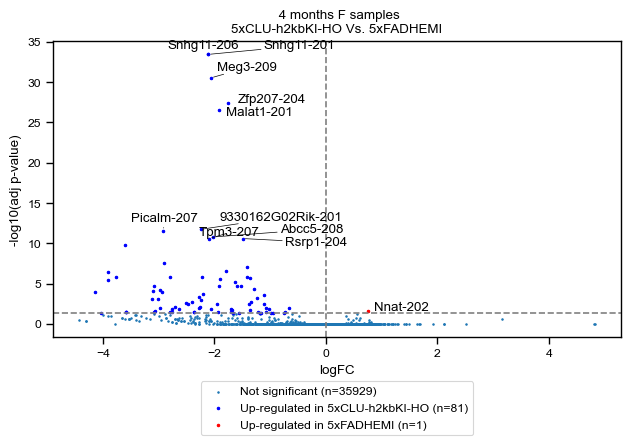

In [26]:
adata_tpm = ad.read_h5ad("data/transcript_exp_tpm.h5ad")
adata_tpm.X = adata_tpm.to_df().apply(pd.to_numeric)

filtering = {'Age': ["4 months"], #c("12mo"),
             'Sex': ["F"], #c("M"),
             'Genotype': ['5xCLU-h2kbKI-HO', '5xFADHEMI']}

if not os.path.exists(f"DIE/"):
    os.makedirs("DIE/", mode=0o777)

fname = f"DIE/{'_'.join(filtering['Genotype'])}_{'_'.join(filtering['Age'])}_{'_'.join(filtering['Sex'])}"

run_deseq2(adata_tpm,
           obs_filtering=filtering,
           obs_condition='Genotype',
           l2fc_thresh=0, 
           adj_p_thresh=0.05,
           label='transcript_name',
           ofile=fname)

## Differential Gene Expression (DGE) analysis

If they also intersted in doing DGE analysis, you first need to calculate the gene expression by summing up the transcript expression for each gene and then adjust the filtering if needed. The filtering structure is similar to DIE.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.85 seconds.

Fitting dispersion trend curve...
... done in 0.23 seconds.

Fitting MAP dispersions...
... done in 1.76 seconds.

Fitting LFCs...
... done in 0.96 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.58 seconds.



Log2 fold change & Wald test p-value: Genotype 5xCLU-h2kbKI-HO vs 5xFADHEMI
                       baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSMUSG00000102693.2  26.139014        0.110623  0.317000  0.348968  0.727113   
ENSMUSG00000051951.6   1.166198        0.468498  1.448066  0.323534  0.746291   
ENSMUSG00000102851.2   0.000000             NaN       NaN       NaN       NaN   
ENSMUSG00000103377.2   0.162738       -0.906424  3.880483 -0.233585  0.815307   
ENSMUSG00000104017.2   0.163249       -0.906424  3.876806 -0.233807  0.815135   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000084166.2   0.822960       -1.840602  1.954414 -0.941767  0.346312   
ENSMUSG00000084014.4   0.163249       -0.906424  3.876806 -0.233807  0.815135   
ENSMUSG00000101407.7   0.489674       -2.387328  2.618530 -0.911705  0.361924   
ENSMUSG00000099351.2  13.461559       -0.194702  0.436822 -0.445725  0.655796   
ENSMUSG00000100011.2  12.472643  

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 59 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'U', 'V', 'a', 'b', 'c', 'd', 'e', 'eight', 'equal', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'j', 'k', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'zero']
INFO:fontTools.subset:Glyp

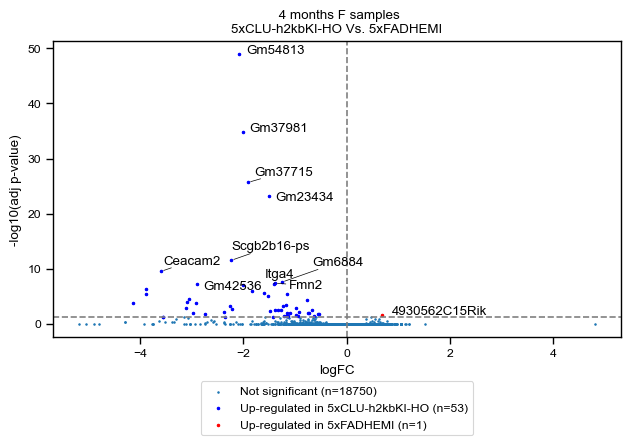

In [27]:
adata_tpm = ad.read_h5ad("data/transcript_exp_tpm.h5ad")
adata_tpm.X = adata_tpm.to_df().apply(pd.to_numeric)

#sum up transcript experssion per genes
df_tpm_gene = adata_tpm.to_df().T.groupby(adata_tpm.var['gene_id']).sum().T
gene_var = adata_tpm.var[['gene_id', 'gene_type', 'gene_name']]
gene_var.index = gene_var.gene_id.tolist()
gene_var.drop_duplicates(inplace=True)
adata_tpm_gene = ad.AnnData(X=df_tpm_gene.values, var=gene_var, obs=adata_tpm.obs)

filtering = {'Age': ["4 months"], #c("12mo"),
             'Sex': ["F"], #c("M"),
             'Genotype': ['5xCLU-h2kbKI-HO', '5xFADHEMI']}

if not os.path.exists(f"DGE/"):
    os.makedirs("DGE/", mode=0o777)

fname = f"DGE/{'_'.join(filtering['Genotype'])}_{'_'.join(filtering['Age'])}_{'_'.join(filtering['Sex'])}"

run_deseq2(adata_tpm_gene,
           obs_filtering=filtering,
           obs_condition='Genotype',
           l2fc_thresh=0, 
           adj_p_thresh=0.05,
           label='gene_name',
           ofile=fname)